In [1]:
import matplotlib.pyplot as plt


def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element

In [2]:
def figure():
    plt.figure(figsize=(2, 2), dpi=200)

In [3]:
import numpy as np


def mean(v):
    return sum(v) / len(v)


def sort_results(metrics, full_metrics, results):

    sorted_results = results.copy()
    sorted_results["seed"] = -1
    idx = sorted_results.pivot_table("logdir", index=full_metrics, aggfunc="count")
    sorted_results = sorted_results.set_index(full_metrics)
    for i in idx.T:
        sorted_results.loc[i, "seed"] = np.arange(10)

    sorted_results.groupby(full_metrics)["seed"].apply(tuple).apply(
        lambda v: v == tuple(range(10))
    ).all().all()
    return sorted_results.reset_index()


import pandas as pd

metrics = [
    "batch_size",
    "conditional",
    "delta",
    "device",
    "learning_rate",
    "loss_distance",
    "model",
    "num_hidden_units",
    "num_output",
    "num_steps",
    "save_emissions",
    "save_frequency",
    "share_model",
    "temperature",
    "time_offset",
    "tqdm",
    "train_ratio",
    "valid_frequency",
    "valid_ratio",
    "variant",
    "repeat",
    "steps",
]
full_metrics = metrics + ["data_mode"]
results = pd.read_csv("../data/Figure4SupplementMultisession_rat.csv").applymap(
    recover_python_datatypes
)

sorted_results = sort_results(metrics, full_metrics, results)

/tmp/ipykernel_215331/2689709213.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  sorted_results.loc[i, "seed"] = np.arange(10)


In [4]:
aggregated_metrics = [m for m in full_metrics if m not in ["repeat", "seed"]]
aggregated_results = sorted_results.groupby(aggregated_metrics).agg(mean).reset_index()
aggregated_results.columns

/tmp/ipykernel_215331/131725128.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  aggregated_results = sorted_results.groupby(aggregated_metrics).agg(mean).reset_index()


Index(['batch_size', 'conditional', 'delta', 'device', 'learning_rate',
       'loss_distance', 'model', 'num_hidden_units', 'num_output', 'num_steps',
       'save_emissions', 'save_frequency', 'share_model', 'temperature',
       'time_offset', 'tqdm', 'train_ratio', 'valid_frequency', 'valid_ratio',
       'variant', 'steps', 'data_mode', 'repeat', 'Unnamed: 0',
       'valid_total_r2', 'valid_position_error', 'test_total_r2',
       'test_position_error', 'train_consistency_raw', 'train_consistency',
       'valid_consistency_raw', 'valid_consistency', 'test_consistency_raw',
       'test_consistency', 'valid_total_r2_raw', 'test_total_r2_raw',
       'valid_position_error_raw', 'test_position_error_raw', 'seed'],
      dtype='object')

In [5]:
idx = (
    aggregated_results[aggregated_results.data_mode == "single-session"]
    .sort_values("train_consistency")
    .groupby("data_mode")
    .tail(1)
    .set_index(aggregated_metrics)
    .index
)
sorted_results.set_index(aggregated_metrics).loc[idx].reset_index().groupby(
    aggregated_metrics + ["seed"]
).mean().reset_index().to_csv("cebra-behavior.csv")

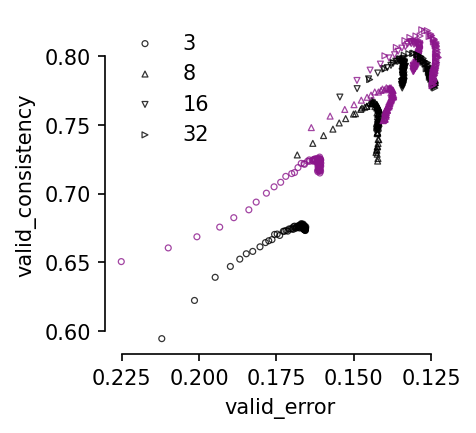

In [6]:
import seaborn as sns


def tradeoff_plot(data, key, condition):
    styles = "1o", "2^", "3v", "4>", "5s"
    plt.figure(figsize=(3, 3), dpi=150)

    for (color, marker), dim in zip(styles, condition):
        filtered_data = data[(data[key] == dim) & (data.data_mode == "single-session")]

        plt.scatter(
            filtered_data.valid_position_error,
            filtered_data.valid_consistency,
            facecolor="none",
            edgecolor=f"black",
            alpha=0.8,
            linewidth=0.6,
            s=8,
            marker=marker,
            label=dim,
        )

        filtered_data = data[(data[key] == dim) & (data.data_mode == "multi-session")]

        plt.scatter(
            filtered_data.valid_position_error,
            filtered_data.valid_consistency,
            facecolor="none",
            edgecolor=f"#8B168B",
            alpha=0.8,
            linewidth=0.6,
            s=8,
            marker=marker,
        )

    plt.legend(frameon=False)
    plt.gca().invert_xaxis()
    sns.despine(trim=True)
    plt.xlabel("valid_error")
    plt.ylabel("valid_consistency")
    plt.show()


data = aggregated_results[aggregated_results.steps > 500].sort_values(
    "valid_position_error"
)
# tradeoff_plot(data, key = 'num_output', condition = [3, 8, 16, 32])
tradeoff_plot(data, key="num_hidden_units", condition=[3, 8, 16, 32])

In [7]:
def compute(sorted_results):
    sorted_results = sorted_results.copy()
    sorted_results["mean_train_consistency"] = sorted_results[
        "train_consistency_raw"
    ].apply(np.mean)

    groupby = [m for m in metrics if m != "repeat"] + ["data_mode"]
    sorted_results

    # .groupby(groupby).mean().sort_values("mean_train_consistency") #.tail(1)

    # .apply(np.mean) #.explode("test_position_error_raw")

    sorted_results = sorted_results[
        (sorted_results.num_hidden_units == 32) & (sorted_results.steps == 5000)
    ].explode("test_position_error_raw")

    sorted_results["animal"] = np.arange(len(sorted_results)) % 4
    return sorted_results


result = (
    compute(sorted_results)
    .pivot_table(
        "test_position_error_raw",
        index=("data_mode", "animal"),
        columns="seed",
        aggfunc="mean",
    )
    .agg(list, axis=1)
    .unstack()
    .T
)

# result.to_pickle("figure4_decoding_results.pkl")

# .sort_values("mean_train_run_consistency"
# ).groupby(["data_mode", "seed", "repeat", "num_output"]
# ).tail(1)

# 10 seeds x 3 repeats

250     20
2750    20
4500    20
4250    20
4000    20
3750    20
3500    20
3250    20
3000    20
2500    20
500     20
2250    20
2000    20
1750    20
1500    20
1250    20
1000    20
750     20
4750    20
Name: steps, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


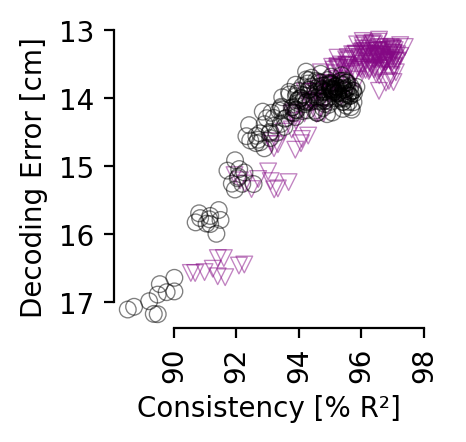

In [8]:
from matplotlib.markers import MarkerStyle

"""
  baseline = sorted_results[
    (sorted_results.num_hidden_units == 32) & 
    (sorted_results.steps == 0)
  ].sort_values("valid_position_error"
  ).groupby(["data_mode", "seed", "repeat", "num_output"]
  ).head(1)
"""


def plot(sorted_results, metric, yaxis):

    filtered_results = (
        sorted_results[
            (sorted_results.num_hidden_units == 32)
            & (sorted_results.num_output == 32)
            & (sorted_results.steps > 100)
            & (sorted_results.steps < 5000)
        ]
        .set_index("data_mode")
        .sort_values("valid_position_error")
        .groupby(["steps", "data_mode", "seed", "repeat", "num_output"])
        .head(1)
    )
    filtered_results = filtered_results[filtered_results.steps % 250 == 0]
    filtered_results["train_consistency"] *= 100
    filtered_results["test_position_error"] *= 100
    # baseline['data_mode'] = "baseline"
    # baseline = baseline.set_index("data_mode").copy()
    # filtered_results = pd.concat([filtered_results, baseline]).sort_values("valid_position_error", ascending = False)

    # fig = sns.catplot(
    #    data=filtered_results.reset_index(), kind="swarm",
    #    hue="data_mode", y=metric, x="data_mode",
    #    palette="dark", alpha=.6, height=6,
    #    legend = False
    # )

    # display(filtered_results)

    filtered_results = filtered_results.groupby(["steps", "data_mode", "seed"]).mean()
    display(filtered_results.reset_index().steps.value_counts())

    plt.figure(figsize=(2, 2), dpi=200)
    sns.scatterplot(
        data=filtered_results.reset_index().sort_values("data_mode"),
        x="train_consistency",
        y="test_position_error",
        style="data_mode",
        hue="data_mode",
        palette=["#840884", "k"],
        markers=[MarkerStyle("v", "none"), MarkerStyle("o", "none")],
        alpha=0.5,
        ci=None,
        legend=False,
    )

    plt.legend(loc=(1, 0), frameon=False)
    plt.xlabel("Consistency [% R²]")

    # fig.figure.set_size_inches(2, 2)
    # fig.figure.set_dpi(200)

    # plt.xlim([.95, 1.0])
    plt.xticks([90, 92, 94, 96, 98])
    # plt.gca().spines["bottom"].set_bounds([.96, 1.0])
    sns.despine(trim=True)
    plt.ylabel(yaxis)
    plt.xlabel("Consistency [% R²]")
    # plt.gca().set_xticklabels(["random", "single", "multi"])
    plt.xticks(rotation=90)
    plt.gca().invert_yaxis()
    plt.show()


plot(sorted_results, metric="test_position_error", yaxis="Decoding Error [cm]")
# plot(sorted_results, metric = "train_consistency", yaxis = "Consistency [R², train]")
# plot(sorted_results, metric = "test_consistency", yaxis = "Consistency [R², test]")

data_mode
multi-session     0.139947
single-session    0.139954
Name: valid_position_error, dtype: float64

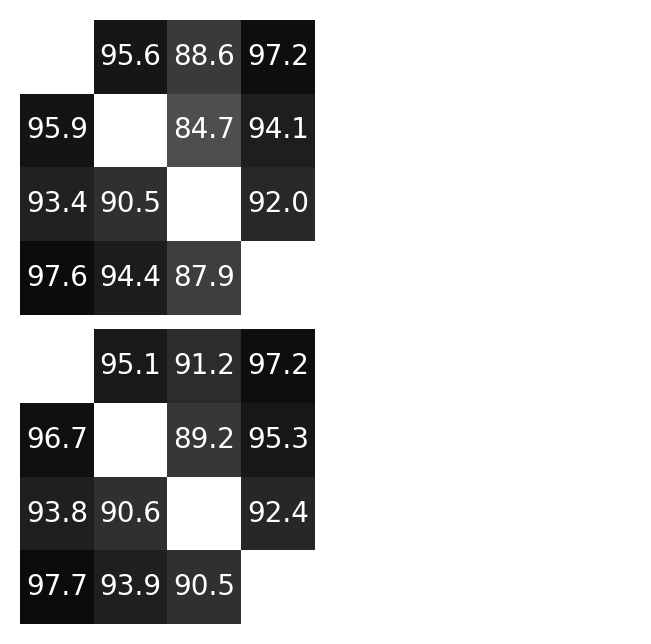

In [9]:
def show_sweep(df):
    for c in df.columns:
        try:
            values = df[c].unique()
        except TypeError:
            continue
        # if len(values) != len(df):
        if len(values) > 1:
            print(c, values)


filtered_results = aggregated_results[
    (aggregated_results.batch_size == 512)
    & (aggregated_results.learning_rate == 0.0003)
    & (aggregated_results.num_output == 32)
    & (aggregated_results.num_hidden_units == 32)
].set_index("data_mode")

filtered_results = filtered_results[filtered_results["valid_position_error"] < 0.14]
display(
    filtered_results.sort_values("valid_position_error")["valid_position_error"]
    .groupby("data_mode")
    .tail(1)
)
filtered_results = (
    filtered_results.sort_values("valid_position_error").groupby("data_mode").tail(1)
)

_, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=200)

for ax_row, data_mode in zip(axes, ["single-session", "multi-session"]):

    for ax, split in zip(ax_row, ["train"]):

        values = filtered_results[f"{split}_consistency_raw"].loc[data_mode]

        cfm = np.zeros((4, 4))
        cfm[:] = float("nan")
        cfm[~np.eye(4).astype(bool)] = values
        sns.heatmap(
            cfm * 100,
            cmap="gray_r",
            vmin=50,
            vmax=100,
            annot=True,
            fmt=".1f",
            square=True,
            cbar=False,
            ax=ax,
        )

for ax in axes.flatten():
    ax.axis("off")

plt.subplots_adjust(wspace=-0.005, hspace=0.05)
plt.show()

In [10]:
filtered_results[f"train_consistency_raw"].loc["multi-session"], filtered_results[
    f"train_consistency_raw"
].loc["single-session"]

(array([0.95081546, 0.91219784, 0.97159572, 0.9668054 , 0.89214698,
        0.95330396, 0.93798715, 0.90619733, 0.92378746, 0.97700708,
        0.93911369, 0.90545486]),
 array([0.95555933, 0.88572262, 0.97200465, 0.9593825 , 0.84737061,
        0.94094321, 0.93445153, 0.90453392, 0.92011637, 0.97647199,
        0.94380083, 0.87852935]))

In [11]:
import scipy.stats

scipy.stats.ttest_rel(
    filtered_results[f"train_consistency_raw"].loc["multi-session"],
    filtered_results[f"train_consistency_raw"].loc["single-session"],
    alternative="greater",
)

Ttest_relResult(statistic=2.2233272445184493, pvalue=0.024042329397411348)

In [12]:
def _select(values):
    index, values = values[0], values[1:]
    return values[index]


def hyperparameter_pivot(
    data, select_with, metric, index=[], columns=[], select_func=np.argmin
):

    idx = data.pivot_table(
        select_with, index=index, columns=columns, aggfunc=lambda v: (select_func(v),)
    )

    agg = data.pivot_table(metric, index=index, columns=columns, aggfunc=tuple)

    if len(agg.columns) == 1:
        idx.columns = [metric]
        agg.columns = [metric]

    return (idx + agg).applymap(_select)


from IPython.display import display, HTML

KEYS = (
    "train_consistency",
    "valid_consistency",
    "test_consistency",
    "valid_position_error",
    "test_position_error",
)


def show_results(select_by="valid_accuracy", func=np.argmax, keys=KEYS):

    frames = (
        hyperparameter_pivot(
            results,
            select_by,
            key,
            index=["data_mode"],
            columns=["batch_size"],
            select_func=func,
        )
        * (100 if "consistency" in key else 1)
        for key in keys
    )

    display(HTML("<style>.container { width:100% !important; }</style>"))

    titles = [
        "Consistency (R², train)",
        "Consistency (R², valid)",
        "Consistency (R², test)",
        "Accuracy (valid)",
        "Accuracy (test)",
    ]

    # summary = pd.concat(frames, axis = 1)
    # summary.columns = titles
    # return HTML(summary.style.format(precision = 2)._repr_html_())

    return HTML(
        ("\xa0" * 3).join(
            frame._repr_html_() + title for frame, title in zip(frames, titles)
        )
    )


select_metrics = ("valid_total_r2",)
for key in select_metrics:
    display(show_results(key))
    print("selected by best", key)

,train_consistency
data_mode,
multi-session,95.259507
single-session,94.677608
,valid_consistency
data_mode,
multi-session,84.270572
single-session,82.158812
,test_consistency
data_mode,
multi-session,89.312167


selected by best valid_total_r2
